In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import scipy.stats as stats
from scipy.stats import kstest
import copy
import xgboost as xgb
from sklearn.metrics import accuracy_score
import sklearn.metrics as skm
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics, linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

### sample set

In [217]:
flights1 = pd.read_csv('flights.csv',low_memory=False).sample(50000, random_state = 42)
flights = copy.deepcopy(flights1)

In [218]:
drop_cols = ['carrier_delay',
'weather_delay',
'nas_delay',
'security_delay',
'late_aircraft_delay',
'first_dep_time',
'total_add_gtime',
'longest_add_gtime',
'no_name','cancellation_code']
flights = flights.drop(drop_cols, axis =1)

In [219]:
date_split = flights['fl_date'].str.split('-')
date_split[:3]
flights['year'] = [x[0] for x in date_split]
flights['month'] = [x[1] for x in date_split]
flights['day'] = [x[2] for x in date_split]

In [ ]:
flights.info()

In [220]:
flights_feature = flights.filter(['fl_date','month','day','mkt_carrier',
                                  'mkt_carrier_fl_num','origin','dest','crs_dep_time',
                                  'distance','crs_arr_time', 'arr_delay'], axis=1)



In [221]:
#flights_feature.isna().sum()

In [222]:
flights_feature['month']=flights_feature['month'].astype(str).astype(int)
flights_feature['day']=flights_feature['day'].astype(str).astype(int)
flights_feature['fl_date'] = pd.to_datetime(flights_feature['fl_date'])
flights_feature['day_of_week'] = flights_feature['fl_date'].dt.dayofweek
bins = [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400]
flights_feature['binned_dep'] = np.searchsorted(bins, flights_feature['crs_dep_time'].values)
flights_feature['binned_arr'] = np.searchsorted(bins, flights_feature['crs_arr_time'].values)
bins = [0, 1100, 4100, 10000]
flights_feature['binned_distance'] = np.searchsorted(bins, flights_feature['distance'].values)

In [223]:
from sklearn.preprocessing import LabelEncoder
flights_feature['carrier_encoded']=LabelEncoder().fit_transform(flights_feature.mkt_carrier )
flights_feature['origin_encoded']=LabelEncoder().fit_transform(flights_feature.origin)
flights_feature['dest_encoded']=LabelEncoder().fit_transform(flights_feature.dest)

### test set

In [224]:
df1 = pd.read_csv('flight_test.csv',low_memory=False).sample(37500, random_state = 42)
df2 = copy.deepcopy(df1)

In [225]:
df1['day'] = pd.DatetimeIndex(df1['fl_date']).day
df1['month'] = pd.DatetimeIndex(df1['fl_date']).month
df1['fl_date'] = pd.to_datetime(df1['fl_date'])
df1['day_of_week'] = df1['fl_date'].dt.dayofweek

In [226]:
test_feature = df1.filter(['month','mkt_carrier',
                                  'mkt_carrier_fl_num','origin','dest','crs_dep_time',
                                  'distance','crs_arr_time','day','day_of_week'], axis=1)

In [227]:
#test_feature['day']=test_feature['day'].astype(str).astype(int)
#test_feature['fl_date'] = pd.to_datetime(test_feature['fl_date'])
#test_feature['day_of_week'] = test_feature['fl_date'].dt.dayofweek

In [228]:
test_feature['month']=test_feature['month'].astype(str).astype(int)
bins = [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400]
test_feature['binned_dep'] = np.searchsorted(bins, test_feature['crs_dep_time'].values)
test_feature['binned_arr'] = np.searchsorted(bins, test_feature['crs_arr_time'].values)
bins = [0, 1100, 4100, 10000]
test_feature['binned_distance'] = np.searchsorted(bins, test_feature['distance'].values)

In [229]:
from sklearn.preprocessing import LabelEncoder
test_feature['carrier_encoded']=LabelEncoder().fit_transform(test_feature.mkt_carrier )
test_feature['origin_encoded']=LabelEncoder().fit_transform(test_feature.origin)
test_feature['dest_encoded']=LabelEncoder().fit_transform(test_feature.dest)

In [230]:
t_feature = test_feature.drop(['mkt_carrier','mkt_carrier_fl_num','origin','dest','crs_dep_time','distance','crs_arr_time'],axis=1)

In [231]:
t_feature = t_feature.drop(['origin_encoded','dest_encoded'],axis=1)

In [232]:
t_feature.to_csv(r't_submit.csv')

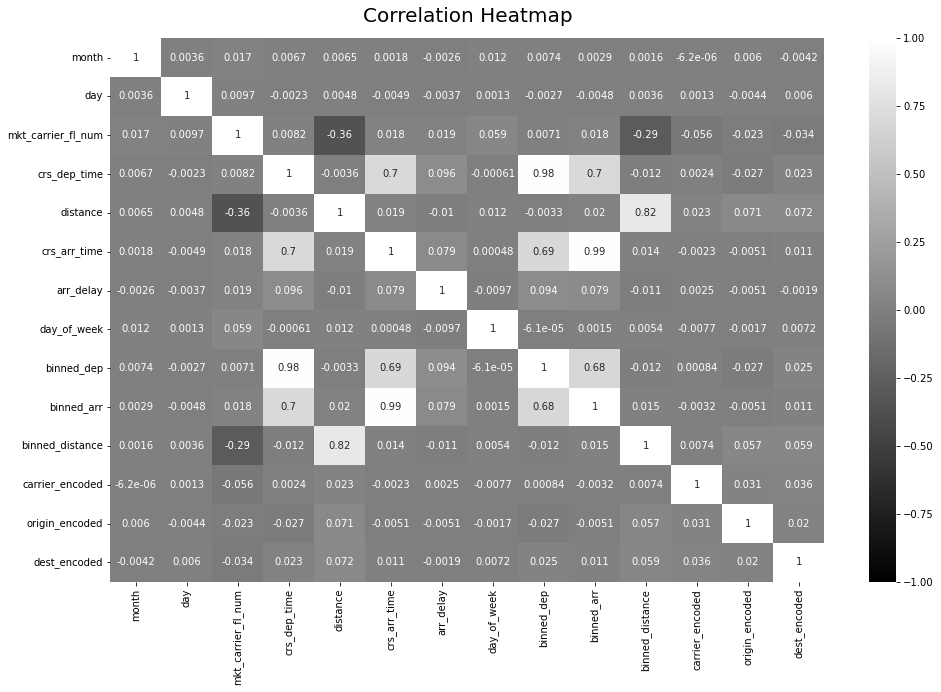

In [233]:
fig, ax = plt.subplots(figsize=(16,10)) 
heatmap = sns.heatmap(flights_feature.corr(), vmin=-1, vmax=1, annot=True, cmap='gray')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=16)
plt.savefig('arrdelayfeatures.png', dpi=300, bbox_inches='tight')

In [234]:
flights_feature.drop(columns=['fl_date','origin','dest','mkt_carrier','crs_dep_time','crs_arr_time','distance'],inplace=True)

In [235]:
flights_feature.arr_delay.mean()

5.342793022544119

In [236]:
##filling null
flights_feature.arr_delay.fillna(flights_feature.arr_delay.mean(),inplace=True)

In [237]:
flights_feature.isna().sum()

month                 0
day                   0
mkt_carrier_fl_num    0
arr_delay             0
day_of_week           0
binned_dep            0
binned_arr            0
binned_distance       0
carrier_encoded       0
origin_encoded        0
dest_encoded          0
dtype: int64

In [238]:
Flights_1=flights_feature[['mkt_carrier_fl_num','carrier_encoded','origin_encoded','dest_encoded','month','day','day_of_week','binned_dep','binned_arr','binned_distance']].copy()
Flights_1.head()

,mkt_carrier_fl_num,carrier_encoded,origin_encoded,dest_encoded,month,day,day_of_week,binned_dep,binned_arr,binned_distance
905525,359,2,179,54,2,21,3,6,7,2
4145140,819,3,20,350,12,20,4,5,5,1
10296996,753,10,87,236,3,1,4,6,7,1
2983446,4374,10,154,299,12,28,4,6,7,1
15919188,5871,8,315,253,8,10,5,4,5,1


In [239]:
X = Flights_1.copy() 
y = flights_feature['arr_delay'] # Target var

# PCA

[0.15981708 0.07239076 0.15362016 0.15063649 0.09642543 0.15412551
 0.10639671 0.04460463 0.04210815 0.01987507]


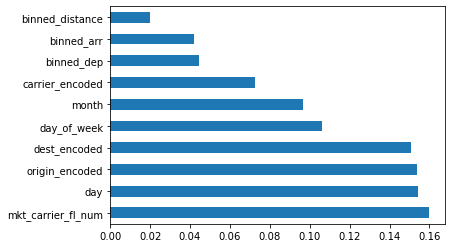

In [240]:
# Feature importance with emsemble 
model = ExtraTreesRegressor(n_estimators=50)
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# XGB Reg

In [241]:
X.columns

Index(['mkt_carrier_fl_num', 'carrier_encoded', 'origin_encoded',
       'dest_encoded', 'month', 'day', 'day_of_week', 'binned_dep',
       'binned_arr', 'binned_distance'],
      dtype='object')

In [242]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [243]:
xgb1 = xgb.XGBRegressor(n_estimators=10000, max_depth=3)
xgb_tr=xgb1.fit(X_train,y_train)



In [244]:
print("Accuracy on training set for XGBoost(n=10000,depth=3): {:.3f}".format(xgb_tr.score(X_train, y_train)))

Accuracy on training set for XGBoost(n=10000,depth=3): 0.807


In [245]:
results = [
('r2', skm.r2_score(y_test,y_pred_xgb) ),
('explained_variance', skm.explained_variance_score(y_test,y_pred_xgb) ),
('Max_Err', skm.max_error(y_test,y_pred_xgb) ),
('Mean_Abs_Err', skm.mean_absolute_error(y_test,y_pred_xgb) ),
('Mean_Sqr_Err', skm.mean_squared_error(y_test,y_pred_xgb) ),
('Median_Abs_Err', skm.median_absolute_error(y_test,y_pred_xgb) ) ]

In [246]:
for score in results:
    print(score)

('r2', -0.4630057585810281)
('explained_variance', -0.4625125250740041)
('Max_Err', 1130.612244606018)
('Mean_Abs_Err', 32.142882351776734)
('Mean_Sqr_Err', 3487.001017649853)
('Median_Abs_Err', 19.84851360321045)


In [247]:
y_xg = xgb_tr.predict(X_test)

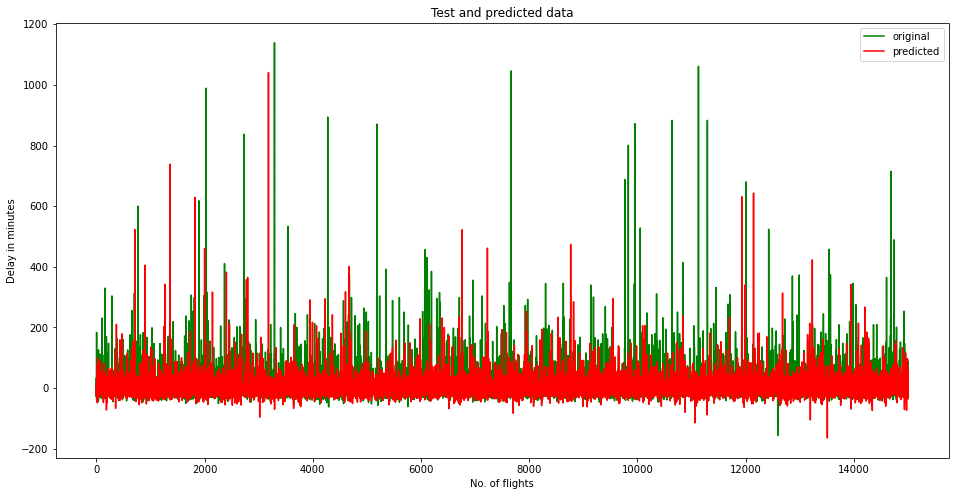

In [248]:
x_ax = range(len(y_test))
fig = plt.figure(figsize=(16,8))
plt.plot(x_ax, y_test, label="original", color= 'green')
plt.plot(x_ax, y_xg, label="predicted", color= 'red')

plt.title("Test and predicted data")
plt.xlabel('No. of flights')
plt.ylabel('Delay in minutes')

plt.legend()
plt.show()

# Linear Reg

In [185]:
# Standard Scaler creation using the fit_transform() method
scaler = StandardScaler()
scaled_X_train = X_train.copy()
scaled_X_test = X_test.copy()
scaled_X_train= scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [188]:
# Fitting the model
LR_model = LinearRegression()
LR_model.fit(scaled_X_train,y_train)

LinearRegression()

In [189]:
y_pred = LR_model.predict(scaled_X_test)

In [192]:
#After training, check the accuracy using actual and predicted values.

print ('Linear Regression R2 score: ',  r2_score(y_test, y_pred))
print ('Linear Regression MAE: ', mean_absolute_error(y_test,y_pred))
print('Linear Regression MSE: ', mean_squared_error(y_test, y_pred))
print('Linear Regression RMSE:', np .sqrt(mean_squared_error(y_test, y_pred)))

Linear Regression R2 score:  0.008055257264943272
Linear Regression MAE:  23.91367209662725
Linear Regression MSE:  2363.484106944345
Linear Regression RMSE: 48.61567758392703


### Hyperparameter tune

In [253]:
model = xgb.XGBRegressor()
params = [{'max_depth': [3,4,5,6], 'n_estimators':[100, 150,200,250], 'colsample_bytree': [0.3, 0.5],
               'learning_rate' : [0.01,0.05,0.1,0.2], 'alpha': [0.1,0.01,0.001,1]}]

In [254]:
# Create an object with the model and parameter candidates
reg = GridSearchCV(estimator=model, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

In [256]:
# Train the classifier on data1's feature and target data
results = reg.fit(scaled_X_train, y_train)

In [ ]:
y_xg_results = results.predict(X_test)

In [ ]:
# View the score
print('Best score:', results.best_score_)
# View the best parameters for the model found using grid search
print('Best parameters: ',results.best_params_) 

In [ ]:
# Apply the best params to the model
results.score(scaled_X_test, y_test)

In [ ]:
# Instantiate XGB Regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 5, alpha = 0.01, n_estimators = 1000)

In [ ]:
xg_reg.fit(X_train,y_train)

# Polynomial Features

In [206]:
# Create polynomial feature set and train model
Xpoly_train = PolynomialFeatures(degree=2).fit_transform(scaled_X_train)
Xpoly_test = PolynomialFeatures(degree=2).fit_transform(scaled_X_test)
print(f'\nNumber of polynomial features: {Xpoly_train.shape[1]}')


Number of polynomial features: 36


In [207]:
# Train our model
LR_model.fit(Xpoly_train, y_train)

LinearRegression()

In [208]:
ypoly_pred = LR_model.predict(Xpoly_test)

In [209]:
print ('ploy R2 score: ',  r2_score(y_test, ypoly_pred))
print ('ploy MAE: ', mean_absolute_error(y_test, ypoly_pred))
print('ploy MSE: ', mean_squared_error(y_test,ypoly_pred))
print('ploy RMSE:', np .sqrt(mean_squared_error(y_test, ypoly_pred)))

ploy R2 score:  0.00865094404902611
ploy MAE:  23.924018552653255
ploy MSE:  2362.064777634716
ploy RMSE: 48.60107794725047


# Random forest regression

In [179]:
flights_feature = flights_feature.drop(['origin_encoded','dest_encoded'],axis=1)

In [171]:
X = flights_feature.drop(['arr_delay','mkt_carrier_fl_num'],axis=1)
y = flights_feature['arr_delay']

In [172]:
scaler = StandardScaler()
scaled_flight = scaler.fit_transform(X)

In [173]:
X_test, X_train, y_test, y_train = train_test_split(scaled_flight, y, test_size=0.25, random_state=42)

In [174]:
clf=RandomForestRegressor(n_estimators=100, max_depth=6)
clf.fit(X_train,y_train)

RandomForestRegressor(max_depth=6)

In [175]:
X.head(5)

,month,day,day_of_week,binned_dep,binned_arr,binned_distance,carrier_encoded
905525,2,21,3,6,7,2,2
4145140,12,20,4,5,5,1,3
10296996,3,1,4,6,7,1,10
2983446,12,28,4,6,7,1,10
15919188,8,10,5,4,5,1,8


In [176]:
t_feature.head()

,month,day,day_of_week,binned_dep,binned_arr,binned_distance,carrier_encoded,origin_encoded,dest_encoded
2062,1,1,2,7,8,1,1,249,292
91028,1,5,6,7,8,1,8,159,152
70112,1,4,5,7,7,1,8,159,105
65684,1,4,5,7,7,1,1,109,303
99068,1,5,6,3,3,2,8,97,88


In [180]:
training_preds = clf.predict(X_train)
y_pred = clf.predict(t_feature.values)

In [181]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Mean squared error: 2394.91
Coefficient of determination: -0.01


In [151]:
pred = pd.DataFrame(y_pred)

In [152]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees 
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
# Max number of levels in tree
max_depth = [6]


min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [153]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.9s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.8s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total t

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [6],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [154]:
y_pred = rf_random.predict(X_test)

In [155]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)

print('rmse: ',rmse)
print('r2_score:', r2)

rmse:  48.46380419781823
r2_score: 0.014243166275400565
